### Exercise: Dual numbers

In [1]:
import numpy as np

class DualValue:
  def __init__(self, value, differential):
    self.value = value
    self.differential = differential
  def __add__(self, other):
    return DualValue(self.value + other.value, self.differential + other.differential)
  def __radd__(self, other):
    return DualValue(self.value + other, self.differential)
  def __sub__(self, other):
    return DualValue(self.value - other.value, self.differential - other.differential)
  def __rsub__(self, other):
    return DualValue(other - self.value, -self.differential)
  def __mul__(self, other):
    return DualValue(self.value * other.value, self.differential * other.value + self.value * other.differential)
  def __rmul__(self, other):
    return DualValue(self.value * other, self.differential * other)
  def __truediv__(self, other):
    return DualValue(self.value / other.value, (self.differential * other.value - self.value * other.differential) / (other.value * other.value))
  def __rtruediv__(self, other):
    return DualValue(other / self.value, -self.differential * other / (self.value * self.value))
  def __neg__(self):
    return DualValue(-self.value, -self.differential)
  def __lt__(self, other):
    return self.value < other.value
  def __le__(self, other):
    return self.value <= other.value
  def __eq__(self, other):
    return self.value == other.value
  def __ne__(self, other):
    return self.value != other.value
  def __gt__(self, other):
    return self.value > other.value
  def __ge__(self, other):
    return self.value >= other.value
  def __abs__(self):
    return DualValue(abs(self.value), self.differential * np.sign(self.value))
  def __str__(self):
    return str(self.value)
  def __pow__(self, other):
    if isinstance(other, DualValue):
      return DualValue(self.value**other.value, self.value**other.value * other.differential * np.log(self.value) + self.differential * other.value * self.value**(other.value - 1))
    else:
      return DualValue(self.value**other, other * self.value**(other - 1) * self.differential)
  def __rpow__(self, other):
    return DualValue(other**self.value, other**self.value * self.differential * np.log(other))
  
x = DualValue(2, 0)
y = DualValue(3, 1)

f = x**(2*y**3)
print(f.value, f.differential)

18014398509481984 6.742779949618588e+17


### Solution: Learning to fit linear data with gradient descent using TensorFlow


Fitted a = 2.981768242438098, b = 2.0097019944347148


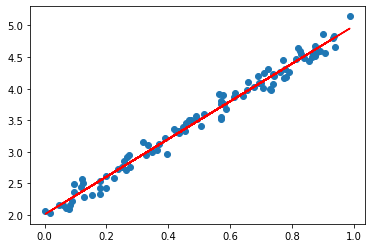

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

xdata = np.random.rand(100, 1)
ydata = 3*xdata + 2 + np.random.randn(100, 1)/10

a = tf.Variable(0, dtype=tf.float64)
b = tf.Variable(0, dtype=tf.float64)
x = tf.constant(xdata, dtype=tf.float64)
yobs = tf.constant(ydata, dtype=tf.float64)

learning_rate = 0.05
for i in range(2000):
  with tf.GradientTape() as tape:
    y = a*x+b
    mse = tf.reduce_sum((y - yobs)**2/xdata.shape[0])
  da, db = tape.gradient(mse, [a, b])
  a.assign_sub(learning_rate*da)
  b.assign_sub(learning_rate*db)

del(tape)

plt.scatter(xdata, ydata)
plt.plot(xdata, a*xdata+b, 'r')

print(f"Fitted a = {a.numpy()}, b = {b.numpy()}")

### Solution: exercise_templates.cc with CUDA

Here is one way to rewrite `exercise_templates.cc` using CUDA.

Notice in the example the call to `cudaDeviceSynchronize`. Calls to GPU and CPU are executed in the order they are issued, but once you make a series of calls to the GPU, they execute concurrently with the rest of the CPU calls. For that reason, before you destruct/deallocate any object that might still be in use by the GPU, you need to make sure that the work of the GPU with that object is complete.

Following the example, the call `free(h_ccx)` could start as soon as the kernel call is issued, right after the `cudaMemcpy` request that also involves `h_cxx` as well. For a large enough `h_cxx` array size, the CPU free operation could start before the CUDA memory copy is complete, unless you ensure the device synchronizes first.


```
#include "cuda_runtime.h"
#include <cstdio>
#include <cuda/std/cassert>



#if (defined(__CUDA_ARCH__) && (__CUDA_ARCH__ > 0))
#define __CUDA_DEVICE_CODE__
#endif
#define __CUDA_HOST_DEVICE__ __host__ __device__
#define __CUDA_GLOBAL__ __global__
#define __CUDA_HOST__ __host__
#define __CUDA_DEVICE__ __device__
// Fancy way to check an error in a CUDA function call
#define __CUDA_CHECK_OR_EXIT_WITH_ERROR__(CALL) \
{ \
  auto __cuda_error_code__ = CALL; \
  if (__cuda_error_code__ != cudaSuccess){ \
    printf("*** CUDA call ***\n*** '%s' ***\n*** at ***\n*** %s::%d ***\n*** failed with error '%s'. ***\n", #CALL, __FILE__, __LINE__, cudaGetErrorString(__cuda_error_code__)); \
    assert(false); \
  } \
}


template<typename T> struct TestClass{
  T x;

  __CUDA_HOST_DEVICE__ TestClass(T const& x) : x(x){}
  __CUDA_HOST_DEVICE__ operator T() const{ return x; }
};
template<> struct TestClass<float>{
  float x;

  __CUDA_HOST_DEVICE__ TestClass(float const& x) : x(x+1e-3f){}
  __CUDA_HOST_DEVICE__ operator float() const{ return x; }
};
template<typename T> struct TestClass<TestClass<T>>{
  T x;

  __CUDA_HOST_DEVICE__ TestClass(TestClass<T> const& x) : x(-x){}
  __CUDA_HOST_DEVICE__ operator T() const{ return x; }
};

template<typename T> __CUDA_HOST_DEVICE__ void print_value(T const& x){
#ifndef __CUDA_DEVICE_CODE__
  printf("CPU printout: Value is %f.\n", static_cast<double>(x));
#else
  printf("GPU printout: Value is %f.\n", static_cast<double>(x));
#endif
}
template<> __CUDA_HOST_DEVICE__ void print_value(float const& x){
#ifndef __CUDA_DEVICE_CODE__
  printf("CPU printout: Twice the value of the float %f is %f.\n", x, 2*x);
#else
  printf("GPU printout: Twice the value of the float %f is %f.\n", x, 2*x);
#endif
}


template<typename T> __CUDA_GLOBAL__ void print_value_kernel(unsigned int n, T* data){
  unsigned int const i = blockIdx.x*blockDim.x + threadIdx.x;
  if (i < n){
    print_value(data[i]);
  }
}


int main(){
  // This is the regular printout from CPU, pretty much unmodified.
  print_value(5); // int
  print_value(2.3); // double
  print_value(5.1f); // float

  // The following lines will call print_value(TestClass<T> const& x) even if operator T() is defined!
  print_value(TestClass<double>(7.25)); // struct initialization with a double type argument
  print_value(TestClass<float>(1.22f)); // struct initialization with a float type argument

  // This is the correct way to force the call print_value(float const& x).
  print_value((float) TestClass<float>(1.22f));

  TestClass<double> cx(87);
  print_value(TestClass<TestClass<double>>(cx));

  /*
  GPU printouts:
  Notice here the execution order and concurrency as well.
  Kernel calls are asynchronous with the CPU, so you need to orchestrate how you wait for the GPU.
  In this example, call (5) running on the CPU does not have to wait for the GPU call sequence (3+4).
  That is why when you call cudaMemcpy, you need to synchronize the GPU device.
  Otherwise, for a large array of data, you could call free(h_ccx) before cudaMemcpy finishes.
  */
  constexpr unsigned int n = 100;
  constexpr unsigned long long int total_size = n*sizeof(TestClass<TestClass<double>>);
  using T = TestClass<TestClass<double>>;

  // Here is one way way to make an array of objects on the host,
  // keeping the memory allocation method in the same style
  // as the allocation of memory on the device. (1)
  T* h_ccx = nullptr;
  h_ccx = (T*) malloc(total_size);
  for (unsigned int i = 0; i < n; ++i) new (h_ccx+i) T(static_cast<double>(i+1)); // Placement new
  // Allocate GPU memory (2)
  T* d_ccx = nullptr;
  __CUDA_CHECK_OR_EXIT_WITH_ERROR__(cudaMalloc(&d_ccx, total_size));
  // Transfer of h_ccx -> d_ccx (3)
  __CUDA_CHECK_OR_EXIT_WITH_ERROR__(cudaMemcpy(d_ccx, h_ccx, total_size, cudaMemcpyHostToDevice));
  // Need to sync the GPU before we eventually free the memory
  __CUDA_CHECK_OR_EXIT_WITH_ERROR__(cudaDeviceSynchronize());
  // Kernel call (4)
  print_value_kernel<<<1, n>>>(n, d_ccx);
  // Can already free the host memory at this point (5)
  free(h_ccx);
  // Free the GPU memory (6)
  __CUDA_CHECK_OR_EXIT_WITH_ERROR__(cudaFree(d_ccx));

  return 0;
}
```

### Solution: Extending shared_ptr

The full implementation is in the folder `IHCcomps`. This is a trimmed version of STL containers from [IvyFramework/IvyHeterogeneousCore](https://github.com/IvyFramework/IvyHeterogeneousCore). If you use some of the material, please kindly cite this repository.
- The file `IvyMemoryHelpers.h` contains the basic memory allocation/deallocation operations. I use the convention 'allocate'/'free' for the 'memalloc'/'free'-equivalent operations. The function that performs 'memcpy'-equivalent operations is `transfer_memory`. In addition to these, I also have functionals to 'construct' and 'destruct' objects, and convenience functions to 'build' (='allocate'+'construct') and 'destroy' (='destruct'+'free') these objects.
- Memory operations on complex class objects are implemented in `memory/IvyAllocator.h` The functions follow a similar logic as in the `IvyMemoryHelpers` namespace. However, memory transfer is now separated for objects that do not have any internal, dynamically allocated data members, and for those that do. This is done through inheriting `transfer_memory_primitive` from either `transfer_memory_primitive_without_internal_memory` (default) or `transfer_memory_primitive_with_internal_memory`. Any class that has such dynamically allocated data members should declare `kernel_generic_transfer_internal_memory` as a `friend`, and should partially specialize `transfer_memory_primitive` to inherit from `transfer_memory_primitive_with_internal_memory`.
- The definition of the unified shared/unique pointer class can be found in `IvyUnifiedPtr.hh`, and the implementation can be found in `IvyUnifiedPtr.h`.

Most of the other files are just helpers, but I also added a few extra files that you can explore on your own. Feel free to contact me over if you have any questions or comments (or if you find any bugs!).